# Experiments: Device networking capabilities over different networking mediums

This notebook allows to run every experiments to determine the networking capabilities of several devices (Fairphone 2 and raspberry pi 5) over several mediums (Wi-Fi 2.4GHz, Wi-Fi 5.0 GHz and Ethernet)

In [123]:
# Imports
import os
import re
import sys
import ast
import time
import pathlib
import datetime
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [117]:
# Config (utility function)
def to_parameters_for_bandwidth_script(medium, sender_ssh, sender_types, receiver_ssh, receiver_types, iterations, duration, omit, number_device, res_dir, reverse=False):
    return ' '.join([
        "--medium", str(medium),
        "--sender-ssh", str(sender_ssh),
        "--sender-types", str(sender_types),
        "--receiver-ssh", str(receiver_ssh),
        "--receiver-types", str(receiver_types),
        "--iterations", str(iterations),
        "" if not reverse else "--reverse",
        "--duration", str(duration),
        "--omit", str(omit),
        "--number-devices", str(number_device),
        "--result-dir", str(res_dir),
    ])

def to_parameters_for_latency_script(medium, sender_ssh, sender_types, receiver_ssh, receiver_types, iterations, count, omit, number_device, workload, res_dir, reverse=False):
    return ' '.join([
        "--medium", str(medium),
        "--sender-ssh", str(sender_ssh),
        "--sender-types", str(sender_types),
        "--receiver-ssh", str(receiver_ssh),
        "--receiver-types", str(receiver_types),
        "--iterations", str(iterations),
        "" if not reverse else "--reverse",
        "--count", str(count),
        "--omit", str(omit),
        "" if not workload else "--with-workload",
        "--number-devices", str(number_device),
        "--result-dir", str(res_dir),
    ])

In [118]:
# Global variables

# Paths
global_res_dir = "./results"
bandwidth_script_path="./scripts/bandwidth_script.sh"
latency_script_path="./scripts/latency_script.sh"

## Experiment 1: Upper bound networking capabilities of each device over several networking mediums

### Bandwidth and latency experiment

#### Experiment setup

In [119]:
# Experiment informations
experiment_name="Upper bound capabilities"
timestamp=datetime.datetime.now() # Current timestamp

# Experiment Settings
medium = ["Ethernet", "WiFi 2.4GHz 20-40MHz", "WiFi 5.0GHz 20-40-80MHz"]
sender_ssh = ["pptc@192.168.88.3", "pi@192.168.88.101"]
sender_types = ["fairphone", "raspberry"]
receiver_ssh = ["corentin@192.168.88.200", "corentin@192.168.88.200"]
receiver_types = ["computer", "computer"]
iterations=10
direction="both"
duration=10
omit=5
number_devices = [1, 1]


df = pd.DataFrame()
df["Sender"] = sender_ssh
df["Sender Type"] = sender_types
df["Receiver"] = receiver_ssh
df["Receiver Type"] = receiver_types
df["Number of devices"] = number_devices
display(df)

,Sender,Sender Type,Receiver,Receiver Type,Number of devices
0,pptc@192.168.88.3,fairphone,corentin@192.168.88.200,computer,1
1,pi@192.168.88.101,raspberry,corentin@192.168.88.200,computer,1


#### Run experiments

In [29]:
# Experiment path
curr_exp_dir = global_res_dir + "/" + experiment_name.replace(' ', '_') + "_" + timestamp.strftime("%Y%m%dT%H%M%S")

for m in medium:
    # Medium paths
    curr_exp_med_dir = curr_exp_dir + "/" + m.replace(' ', '_')
    # Bandwidth paths
    curr_exp_med_bandwidth_dir = curr_exp_med_dir + "/bandwidth"
    curr_exp_med_bandwidth_raw_dir = curr_exp_med_bandwidth_dir + "/raw_results"
    curr_exp_med_bandwidth_res_dir = curr_exp_med_bandwidth_dir + "/results"
    # Latency paths
    curr_exp_med_latency_dir = curr_exp_med_dir + "/latency"
    curr_exp_med_latency_raw_dir = curr_exp_med_latency_dir + "/raw_results"
    curr_exp_med_latency_res_dir = curr_exp_med_latency_dir + "/results"

    # Create results dir
    path = Path(curr_exp_med_bandwidth_raw_dir)
    path.mkdir(parents=True, exist_ok=True)
    path = Path(curr_exp_med_bandwidth_res_dir)
    path.mkdir(parents=True, exist_ok=True)
    path = Path(curr_exp_med_latency_raw_dir)
    path.mkdir(parents=True, exist_ok=True)
    path = Path(curr_exp_med_latency_res_dir)
    path.mkdir(parents=True, exist_ok=True)

    for i in range(df.shape[0]):
        sender_ssh = df.loc[i, "Sender"]
        sender_types = df.loc[i, "Sender Type"]
        receiver_ssh = df.loc[i, "Receiver"]
        receiver_types = df.loc[i, "Receiver Type"]
        n_dev = df.loc[i, "Number of devices"]

        print(f"Prepare next config:\n\tMedium: {m}\n\tSender {sender_ssh} of type {sender_types}\n\tReceiver {receiver_ssh} of type {receiver_types}\n")
        input("Press ENTER to run the benchmark")
        print("Run benchmark...")

        m = m.replace(' ', '_')

        # # Run bandwidth test
        parameters = to_parameters_for_bandwidth_script(m, sender_ssh, sender_types, receiver_ssh, receiver_types, iterations, duration, omit, n_dev, curr_exp_med_bandwidth_raw_dir, False)
        ! {bandwidth_script_path} {parameters}

        # # Run reverse bandwidth test
        parameters_reverse = to_parameters_for_bandwidth_script(m, sender_ssh, sender_types, receiver_ssh, receiver_types, iterations, duration, omit, n_dev, curr_exp_med_bandwidth_raw_dir, True)
        ! {bandwidth_script_path} {parameters_reverse}

        # Run latency test
        parameters = to_parameters_for_latency_script(m, sender_ssh, sender_types, receiver_ssh, receiver_types, iterations, duration, omit, n_dev, False, curr_exp_med_latency_raw_dir, False)
        ! {latency_script_path} {parameters}
        
    
        # Run reverse latency test
        parameters_reverse = to_parameters_for_latency_script(m, sender_ssh, sender_types, receiver_ssh, receiver_types, iterations, duration, omit, n_dev, False, curr_exp_med_latency_raw_dir, True)
        ! {latency_script_path} {parameters_reverse}

NameError: name 'experiment_name' is not defined

In [39]:
# Process bandwidth raw results
def process_bandwidth_raw_results_to_dataframe(raw_results_path):
    def is_data_line(line):
        return "[  6]" in line and "sec" in line and "sender" not in line and "receiver" not in line and "omitted" not in line

    def to_Mbits(value, unit):
        if unit == "Mbits/sec":
            return value, unit
        elif unit == "kbits/sec":
            return value/1000, "Mbits/sec"
        else:
            return RuntimeError()
        
    df = pd.DataFrame(columns=["Bandwidth (in Mbits/sec)", "Retry"])
    medium = ""
    sender = ""
    sender_type = ""
    receiver = ""
    receiver_type = ""
    n_devices = 0
    n_parallel_connections = 0
    data_list = []
    retry_list = []

    with open(raw_results_path, "r") as raw:
        for line in raw:
            if line.startswith("# MEDIUM="):
                medium = line.split('=')[1].strip()
            elif line.startswith("# SENDER="):
                sender = line.split('=')[1].strip()
            elif line.startswith("# SENDER_TYPE="):
                sender_type = line.split('=')[1].strip()
            elif line.startswith("# RECEIVER="):
                receiver = line.split('=')[1].strip()
            elif line.startswith("# RECEIVER_TYPE="):
                receiver_type = line.split('=')[1].strip()
            elif line.startswith("# NUMBER_DEVICES="):
                n_devices = line.split('=')[1].strip()
            elif line.startswith("# PARALLEL_CONNECTIONS="):
                n_parallel_connections = line.split('=')[1].strip()
            elif line.startswith("#"):
                continue
            elif is_data_line(line):
                s = re.sub("\s\s+", " ", line)
                splitted = s.split(" ")
                data = splitted[6]
                unit = splitted[7]
                retry_list.append(splitted[8])
                data, unit = to_Mbits(data, unit)
                data_list.append(data)

    df["Bandwidth (in Mbits/sec)"] = data_list
    df["Retry"] = retry_list
    df["Medium"] = [medium] * df.shape[0]
    df["Sender"] = [sender] * df.shape[0]
    df["Sender Type"] = [sender_type] * df.shape[0]
    df["Receiver"] = [receiver] * df.shape[0]
    df["Receiver Type"] = [receiver_type] * df.shape[0]
    df["Number of devices"] = [n_devices] * df.shape[0]
    df["Parallel connections"] = [n_parallel_connections] * df.shape[0]

    return df

#### Process results

In [50]:
# Process latency raw results
def process_latency_raw_results_to_dataframe(raw_results_path):
    def is_data_line(line, omit):
        l = line.split(' ')
        if "icmp_seq=" in line and int(l[4].split('=')[1]) > omit:
            return True
        elif "seq=" in line and not "icmp_seq=" in line and int(l[4].split('=')[1]) >= omit:
            return True
        else:
            return False

        
    def to_ms(value, unit):
        if unit == "ms":
            return value, unit
        elif unit == "s":
            return value/1000, "ms"
        else:
            return RuntimeError()

    df = pd.DataFrame()
    medium = ""
    sender = ""
    sender_type = ""
    receiver = ""
    receiver_type = ""
    omit = 0
    n_devices = 0
    n_parallel_connections = 0
    workload = False
    data_list = []

    with open(raw_results_path, "r") as raw:
        for line in raw:
            if line.startswith("# MEDIUM="):
                medium = line.split('=')[1].strip()
            elif line.startswith("# SENDER="):
                sender = line.split('=')[1].strip()
            elif line.startswith("# SENDER_TYPE="):
                sender_type = line.split('=')[1].strip()
            elif line.startswith("# RECEIVER="):
                receiver = line.split('=')[1].strip()
            elif line.startswith("# RECEIVER_TYPE="):
                receiver_type = line.split('=')[1].strip()
            elif line.startswith("# OMIT="):
                omit = int(line.split('=')[1].strip())
            elif line.startswith("# NUMBER_DEVICES="):
                n_devices = line.split('=')[1].strip()
            elif line.startswith("# PARALLEL_CONNECTIONS="):
                n_parallel_connections = line.split('=')[1].strip()
            elif line.startswith("# WORKLOAD="):
                workload = True if line.split('=')[1].strip() == str(1) else False
            elif line.startswith("#"):
                continue
            elif is_data_line(line, omit):
                s = re.sub("\s\s+", " ", line)
                splitted = s.split(" ")
                data = splitted[6].split('=')[1]
                unit = splitted[7].strip()
                data, unit = to_ms(data, unit)
                data_list.append(data)

    df["Latency (in ms)"] = data_list
    df["Medium"] = [medium] * df.shape[0]
    df["Sender"] = [sender] * df.shape[0]
    df["Sender Type"] = [sender_type] * df.shape[0]
    df["Receiver"] = [receiver] * df.shape[0]
    df["Receiver Type"] = [receiver_type] * df.shape[0]
    df["Number of devices"] = [n_devices] * df.shape[0]
    df["Parallel connections"] = [n_parallel_connections] * df.shape[0]
    df["Workload"] = [workload] * df.shape[0]

    return df

In [52]:
# Process raw results

exp_dir = global_res_dir + "/" + experiment_name.replace(' ', '_') + "_" + timestamp.strftime("%Y%m%dT%H%M%S")

exp_dir = global_res_dir + "/" + experiment_name.replace(' ', '_') + "_20240804T135449"

df_bandwidth = []
df_latency = []

for medium in os.listdir(exp_dir):
    exp_med_dir = exp_dir + "/" + medium
    # Bandwidth
    exp_med_bandwidth_dir = exp_med_dir + "/bandwidth"
    exp_med_bandwidth_raw_dir = exp_med_bandwidth_dir + "/raw_results"
    exp_med_bandwidth_res_dir = exp_med_bandwidth_dir + "/results"

    df_bandwidth_med = []

    for file in os.listdir(exp_med_bandwidth_raw_dir):
        if "sender" in file:
            df_bandwidth_med.append(process_bandwidth_raw_results_to_dataframe(exp_med_bandwidth_raw_dir + "/" + file))

    df_bandwidth_med = pd.concat(df_bandwidth_med, ignore_index=True)
    df_bandwidth.append(df_bandwidth_med)

    df_bandwidth_med.to_csv(exp_med_bandwidth_res_dir + "/bandwidth_results_" + medium + ".csv", index=False)

    # Latency
    exp_med_latency_dir = exp_med_dir + "/latency"
    exp_med_latency_raw_dir = exp_med_latency_dir + "/raw_results"
    exp_med_latency_res_dir = exp_med_latency_dir + "/results"

    df_latency_med = []

    for file in os.listdir(exp_med_latency_raw_dir):
        if "sender" in file:
            df_latency_med.append(process_latency_raw_results_to_dataframe(exp_med_latency_raw_dir + "/" + file))

    df_latency_med = pd.concat(df_latency_med, ignore_index=True)
    df_latency.append(df_latency_med)

    df_latency_med.to_csv(exp_med_latency_res_dir + "/latency_results_" + medium + ".csv", index=False)

df_bandwidth = pd.concat(df_bandwidth, ignore_index=True)
df_latency = pd.concat(df_latency, ignore_index=True)

df_bandwidth.to_csv(exp_dir + "/bandwidth_results.csv", index=False)
df_latency.to_csv(exp_dir + "/latency_results.csv", index=False)

display(df_bandwidth)
display(df_latency)

    


,Bandwidth (in Mbits/sec),Retry,Medium,Sender,Sender Type,Receiver,Receiver Type,Number of devices,Parallel connections
0,294,0,WiFi_5.0GHz_20-40-80MHz,pi@192.168.88.101,raspberry,corentin@192.168.88.200,computer,1,1
1,283,0,WiFi_5.0GHz_20-40-80MHz,pi@192.168.88.101,raspberry,corentin@192.168.88.200,computer,1,1
2,294,0,WiFi_5.0GHz_20-40-80MHz,pi@192.168.88.101,raspberry,corentin@192.168.88.200,computer,1,1
3,283,0,WiFi_5.0GHz_20-40-80MHz,pi@192.168.88.101,raspberry,corentin@192.168.88.200,computer,1,1
4,294,0,WiFi_5.0GHz_20-40-80MHz,pi@192.168.88.101,raspberry,corentin@192.168.88.200,computer,1,1
...,...,...,...,...,...,...,...,...,...
1195,94.4,0,Ethernet,corentin@192.168.88.200,computer,pptc@192.168.88.3,fairphone,1,1
1196,94.4,0,Ethernet,corentin@192.168.88.200,computer,pptc@192.168.88.3,fairphone,1,1
1197,94.4,0,Ethernet,corentin@192.168.88.200,computer,pptc@192.168.88.3,fairphone,1,1
1198,94.4,0,Ethernet,corentin@192.168.88.200,computer,pptc@192.168.88.3,fairphone,1,1


,Latency (in ms),Medium,Sender,Sender Type,Receiver,Receiver Type,Number of devices,Parallel connections,Workload
0,12.440,WiFi_5.0GHz_20-40-80MHz,pptc@192.168.88.3,fairphone,corentin@192.168.88.200,computer,1,1,False
1,12.630,WiFi_5.0GHz_20-40-80MHz,pptc@192.168.88.3,fairphone,corentin@192.168.88.200,computer,1,1,False
2,12.398,WiFi_5.0GHz_20-40-80MHz,pptc@192.168.88.3,fairphone,corentin@192.168.88.200,computer,1,1,False
3,12.711,WiFi_5.0GHz_20-40-80MHz,pptc@192.168.88.3,fairphone,corentin@192.168.88.200,computer,1,1,False
4,12.422,WiFi_5.0GHz_20-40-80MHz,pptc@192.168.88.3,fairphone,corentin@192.168.88.200,computer,1,1,False
...,...,...,...,...,...,...,...,...,...
1195,0.349,Ethernet,corentin@192.168.88.200,computer,pptc@192.168.88.3,fairphone,1,1,False
1196,0.355,Ethernet,corentin@192.168.88.200,computer,pptc@192.168.88.3,fairphone,1,1,False
1197,0.392,Ethernet,corentin@192.168.88.200,computer,pptc@192.168.88.3,fairphone,1,1,False
1198,0.422,Ethernet,corentin@192.168.88.200,computer,pptc@192.168.88.3,fairphone,1,1,False


#### Make graphs

In [120]:
# Global variables
exp_dir = global_res_dir + "/" + experiment_name.replace(' ', '_') + "_" + timestamp.strftime("%Y%m%dT%H%M%S")

exp_dir = global_res_dir + "/" + experiment_name.replace(' ', '_') + "_20240804T135449"

graphs_dir = exp_dir + "/graphs"
bandwidth_graphs_dir = graphs_dir + "/bandwidth"
latency_graphs_dir = graphs_dir + "/latency"

path = Path(bandwidth_graphs_dir)
path.mkdir(parents=True, exist_ok=True)
path = Path(latency_graphs_dir)
path.mkdir(parents=True, exist_ok=True)



##### Bandwidth

,Bandwidth (in Mbits/sec),Retry,Medium,Sender,Sender Type,Receiver,Receiver Type,Number of devices,Parallel connections
0,294.0,0,WiFi_5.0GHz_20-40-80MHz,pi@192.168.88.101,raspberry,corentin@192.168.88.200,computer,1,1
1,283.0,0,WiFi_5.0GHz_20-40-80MHz,pi@192.168.88.101,raspberry,corentin@192.168.88.200,computer,1,1
2,294.0,0,WiFi_5.0GHz_20-40-80MHz,pi@192.168.88.101,raspberry,corentin@192.168.88.200,computer,1,1
3,283.0,0,WiFi_5.0GHz_20-40-80MHz,pi@192.168.88.101,raspberry,corentin@192.168.88.200,computer,1,1
4,294.0,0,WiFi_5.0GHz_20-40-80MHz,pi@192.168.88.101,raspberry,corentin@192.168.88.200,computer,1,1
...,...,...,...,...,...,...,...,...,...
1195,94.4,0,Ethernet,corentin@192.168.88.200,computer,pptc@192.168.88.3,fairphone,1,1
1196,94.4,0,Ethernet,corentin@192.168.88.200,computer,pptc@192.168.88.3,fairphone,1,1
1197,94.4,0,Ethernet,corentin@192.168.88.200,computer,pptc@192.168.88.3,fairphone,1,1
1198,94.4,0,Ethernet,corentin@192.168.88.200,computer,pptc@192.168.88.3,fairphone,1,1


/tmp/ipykernel_264686/217869524.py:31: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.boxplot(data=item, y="Bandwidth (in Mbits/sec)", x="Connection Label", ax=ax1, palette=colors)
/tmp/ipykernel_264686/217869524.py:32: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.boxplot(data=item, y="Bandwidth (in Mbits/sec)", x="Connection Label", ax=ax2, palette=colors)


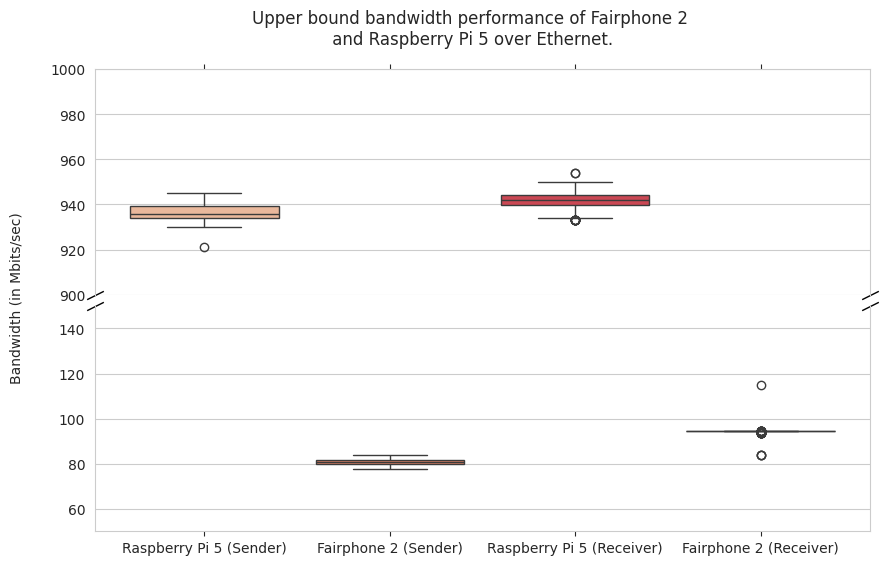

/tmp/ipykernel_264686/217869524.py:65: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.boxplot(data=item, x='Connection Label', y='Bandwidth (in Mbits/sec)', palette=colors)
/tmp/ipykernel_264686/217869524.py:65: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.boxplot(data=item, x='Connection Label', y='Bandwidth (in Mbits/sec)', palette=colors)


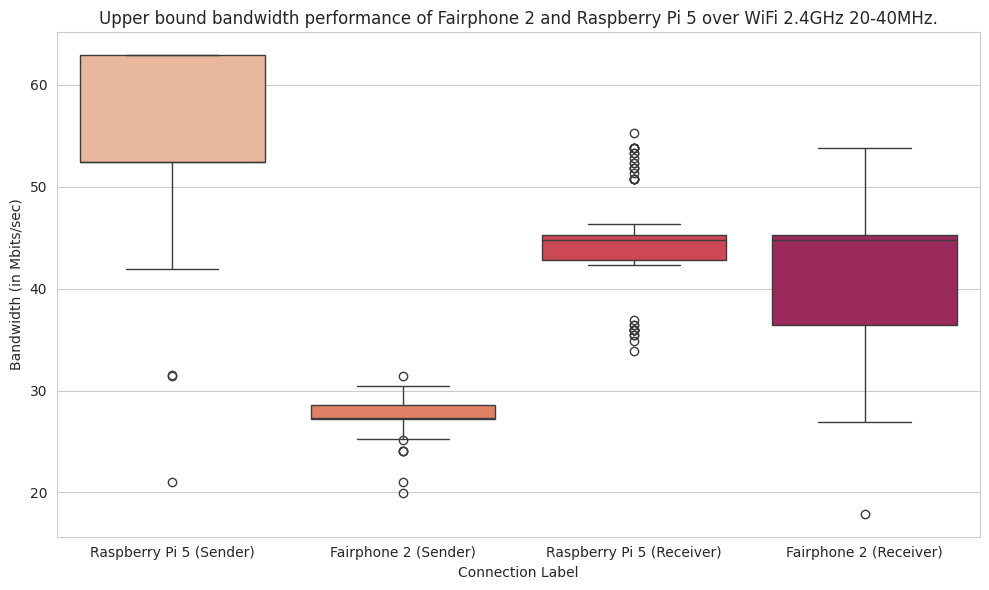

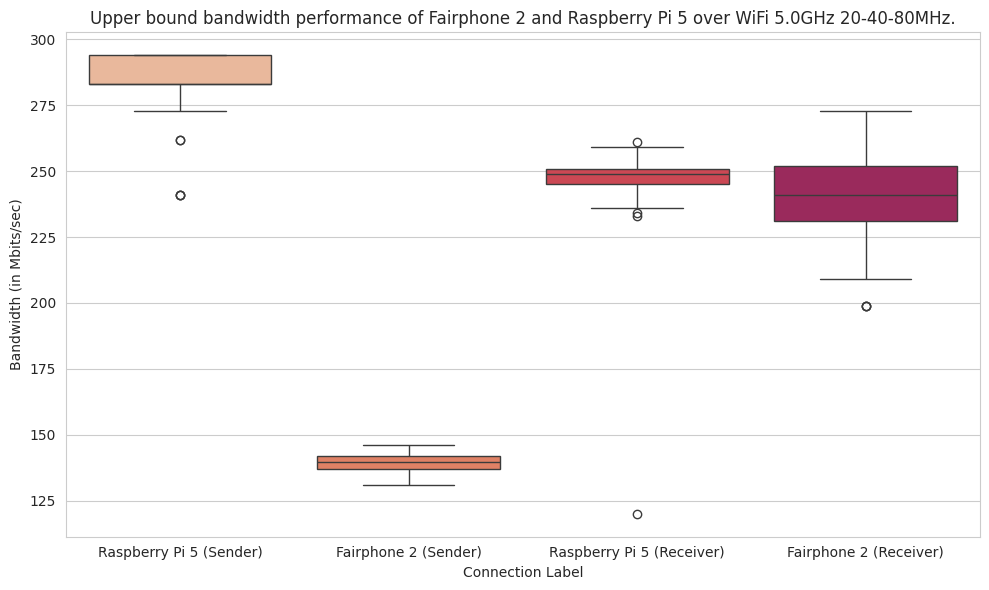

In [128]:
df = pd.read_csv(exp_dir + "/bandwidth_results.csv")

# connection type
connection_labels = []
for s, r in zip(df["Sender Type"], df["Receiver Type"]):
    if s == "raspberry":
        connection_labels.append("Raspberry Pi 5 (Sender)")
    elif s == "fairphone":
        connection_labels.append("Fairphone 2 (Sender)")
    elif r == "raspberry":
        connection_labels.append("Raspberry Pi 5 (Receiver)")
    elif r == "fairphone":
        connection_labels.append("Fairphone 2 (Receiver)")
df["Connection Label"] = connection_labels

# group by medium type
medium_group = df.groupby("Medium")

colors = sns.color_palette('rocket')[::-1]

for key, item in medium_group:
    if key == "Ethernet":
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
        fig.set_figheight(6)
        fig.set_figwidth(10)

        fig.subplots_adjust(hspace=0.05)
        sns.set_style("whitegrid")


        sns.boxplot(data=item, y="Bandwidth (in Mbits/sec)", x="Connection Label", ax=ax1, palette=colors)
        sns.boxplot(data=item, y="Bandwidth (in Mbits/sec)", x="Connection Label", ax=ax2, palette=colors)

        ax1.set_ylim(900, 1000)
        ax2.set_ylim(50, 150)

        ax1.spines.bottom.set_visible(False)
        ax2.spines.top.set_visible(False)
        ax1.xaxis.tick_top()
        ax1.tick_params(labeltop=False)  # don't put tick labels at the top
        ax2.xaxis.tick_bottom()

        d = .5  # proportion of vertical to horizontal extent of the slanted line
        kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                    linestyle="none", color='k', mec='k', mew=1, clip_on=False)
        ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
        ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

        ax1.set_xlabel('')
        ax2.set_xlabel('')
        ax1.set_ylabel('')
        ax2.set_ylabel('')
        ax1.set_title('')
        ax2.set_title('')

        fig.suptitle(f"Upper bound bandwidth performance of Fairphone 2\n and Raspberry Pi 5 over {key.replace('_', ' ')}.")
        fig.text(0.04, 0.5, 'Bandwidth (in Mbits/sec)', va='center', rotation='vertical')

        plt.show()

        fig.savefig(bandwidth_graphs_dir + "/" + experiment_name.replace(' ', '_') + "_bandwidth_" + key + ".pdf")
    else:
        plt.figure(figsize=(10, 6))
        sns.set_style("whitegrid")
        sns.boxplot(data=item, x='Connection Label', y='Bandwidth (in Mbits/sec)', palette=colors)
        plt.title(f"Upper bound bandwidth performance of Fairphone 2 and Raspberry Pi 5 over {key.replace('_', ' ')}.")
        plt.tight_layout()
        
        plt.show

        plt.savefig(bandwidth_graphs_dir + "/" + experiment_name.replace(' ', '_') + "_bandwidth_" + key + ".pdf")

##### Latency

/tmp/ipykernel_264686/3777208140.py:24: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.boxplot(data=item, x='Connection Label', y='Latency (in ms)', palette=colors)
/tmp/ipykernel_264686/3777208140.py:24: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.boxplot(data=item, x='Connection Label', y='Latency (in ms)', palette=colors)
/tmp/ipykernel_264686/3777208140.py:24: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.boxplot(data=item, x='Connection Label', y='Latency (in ms)', palette=colors)


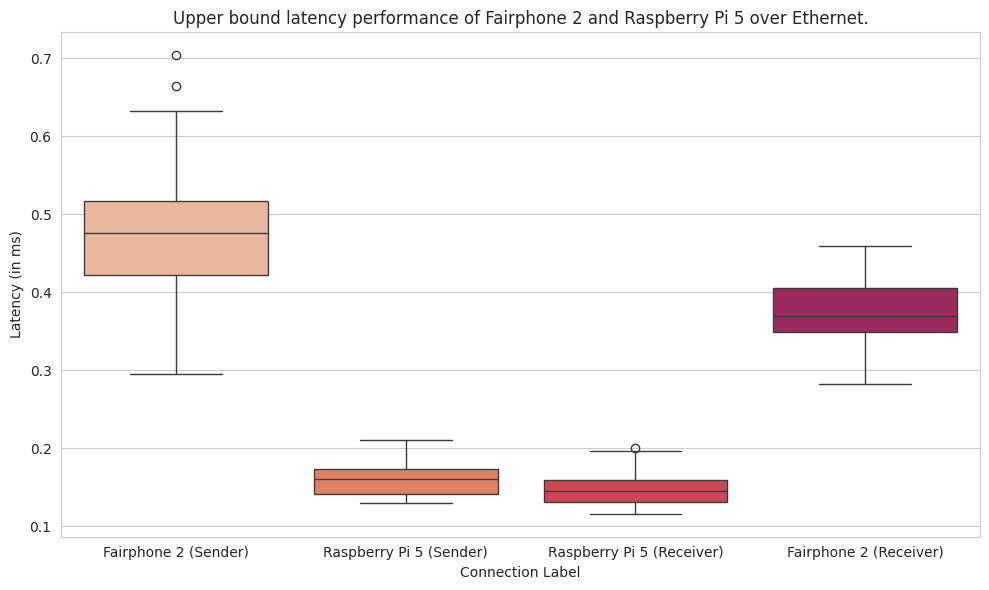

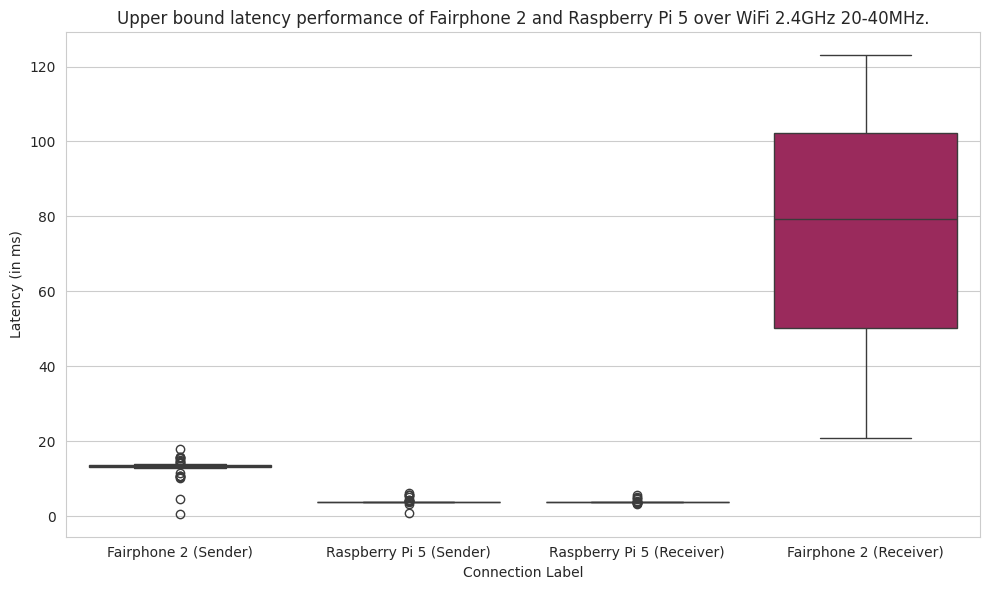

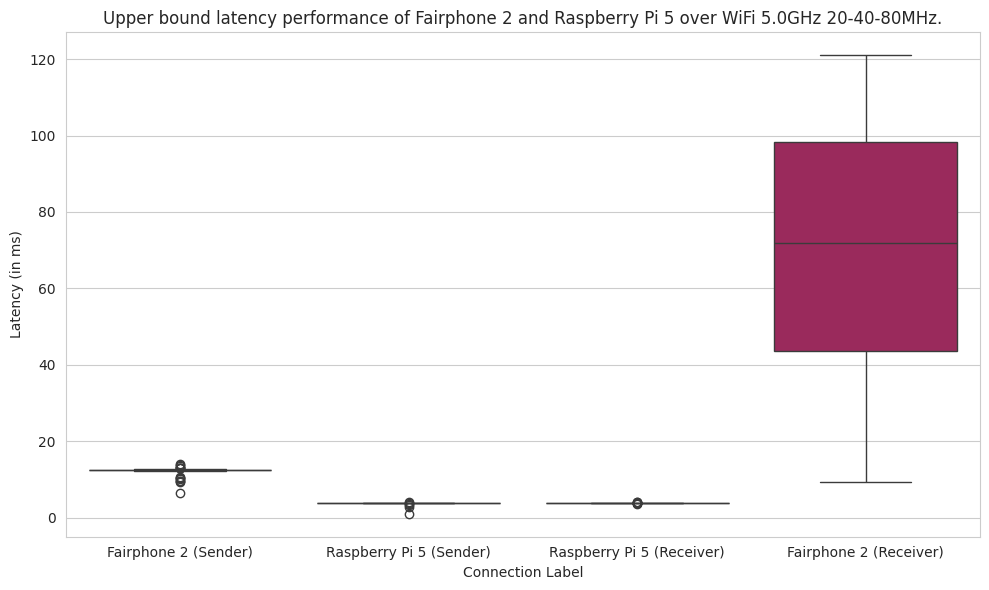

In [129]:
df = pd.read_csv(exp_dir + "/latency_results.csv")

# connection type
connection_labels = []
for s, r in zip(df["Sender Type"], df["Receiver Type"]):
    if s == "raspberry":
        connection_labels.append("Raspberry Pi 5 (Sender)")
    elif s == "fairphone":
        connection_labels.append("Fairphone 2 (Sender)")
    elif r == "raspberry":
        connection_labels.append("Raspberry Pi 5 (Receiver)")
    elif r == "fairphone":
        connection_labels.append("Fairphone 2 (Receiver)")
df["Connection Label"] = connection_labels

# group by medium type
medium_group = df.groupby("Medium")

colors = sns.color_palette('rocket')[::-1]

for key, item in medium_group:
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")
    sns.boxplot(data=item, x='Connection Label', y='Latency (in ms)', palette=colors)
    plt.title(f"Upper bound latency performance of Fairphone 2 and Raspberry Pi 5 over {key.replace('_', ' ')}.")
    plt.tight_layout()
    plt.show

    plt.savefig(latency_graphs_dir + "/" + experiment_name.replace(' ', '_') + "_latency_" + key + ".pdf")